In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.visualization.projections import scatter_spec, scatter_projections
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [4]:
DATASET_ID = 'swamp_sparrow'

In [5]:
syllable_df = pd.read_pickle(DATA_DIR / 'embeddings' / DATASET_ID / 'full-pad.pickle')

In [6]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,rate,spectrogram,umap,umap_0.5,umap_0.25
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.6040968894958496, 0.3447246253490448]","[3.518047571182251, 5.548501491546631]","[3.518047571182251, 5.548501491546631]"
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-1.3377597332000732, -8.327210426330566]","[-3.215000629425049, -8.556021690368652]","[-3.215000629425049, -8.556021690368652]"
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.2666425704956055, 0.9329612255096436]","[6.672956466674805, 6.500638484954834]","[6.672956466674805, 6.500638484954834]"


In [7]:
len(syllable_df.indv.unique())

615

In [8]:
### get population info

In [9]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [10]:
DATASET_ID = 'swamp_sparrow'
hparams = HParams()
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    6.6s


[Parallel(n_jobs=-1)]: Done 1867 out of 1867 | elapsed:    6.9s finished


In [11]:
population = [
    str(i)
    for i in np.array(
        [
            dataset.data_files[key].data["POPID"] if key in dataset.data_files else None
            for key in tqdm(syllable_df.key.values)
        ]
    )
]
np.unique(population)

array(['Adirondacks, NY', 'Conneaut, PA', 'Horicon, WI',
       'Hudson Valley, NY', 'Montezuma, NY', 'None', 'Waterloo, MI'],
      dtype='<U17')

In [12]:
syllable_df['population'] = population

In [13]:
mask = syllable_df.population != 'None'
syllable_df = syllable_df[mask]

In [14]:
specs = np.stack(syllable_df['spectrogram'].values)
embedding = np.vstack(syllable_df['umap'].values)
#embedding = np.vstack(syllable_df['umap_0.5'].values)

In [15]:
np.shape(embedding)

(97453, 2)

In [16]:
def remove_outliers(z, pct = 99.5):
    """ GPU based UMAP algorithm produces some outliers that UMAP does not, but is much faster
    this is a quick fix for that. 
    """
    _min = np.percentile(z, (100-pct), axis=0)
    _max = np.percentile(z, pct, axis=0)
    for col in range(np.shape(z)[1]):
        mask = z[:,col] < _min[col]
        z[mask,col] = _min[col]
        mask = z[:,col] > _max[col]
        z[mask,col] = _max[col]
    return z

(-15, 15)

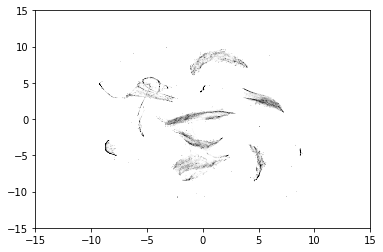

In [17]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 0.005)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [18]:
#embedding[:,0] = embedding[:,0]*-1

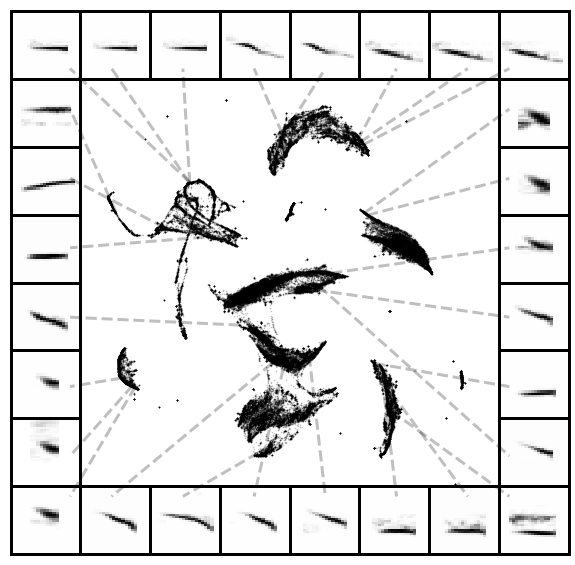

In [19]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        #'labels': syllable_df.labels.values[:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_pdf=True, save_jpg=True, save_png=True)

In [20]:
np.shape(embedding)

(97453, 2)

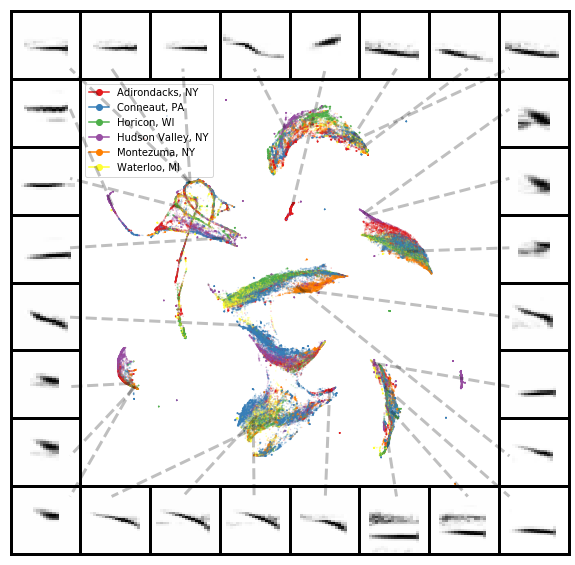

In [21]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.population.values[:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': True,
        'color_palette':'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp_community_taper_0', dpi=300, save_pdf=True, save_jpg=True, save_png=True)

In [22]:
embedding = np.vstack(syllable_df['umap_0.25'].values)

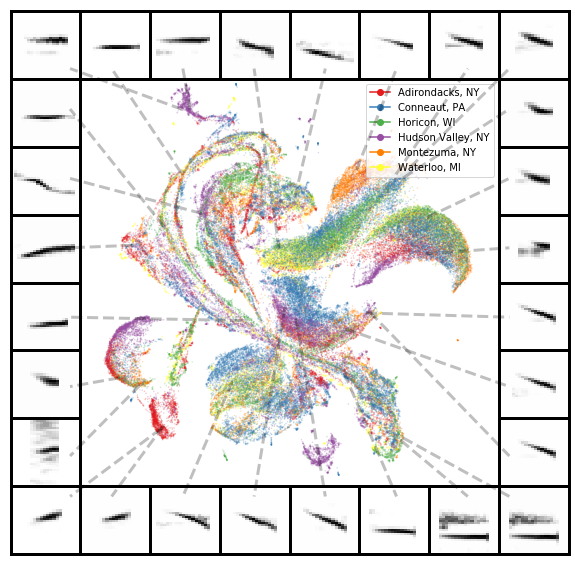

In [28]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.population.values[:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': True,
        'color_palette':'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp_community-taper_0-25', dpi=300,save_pdf =True, save_jpg=True, save_png=True)

In [24]:
mask = syllable_df.pos_in_syllable.values < 5

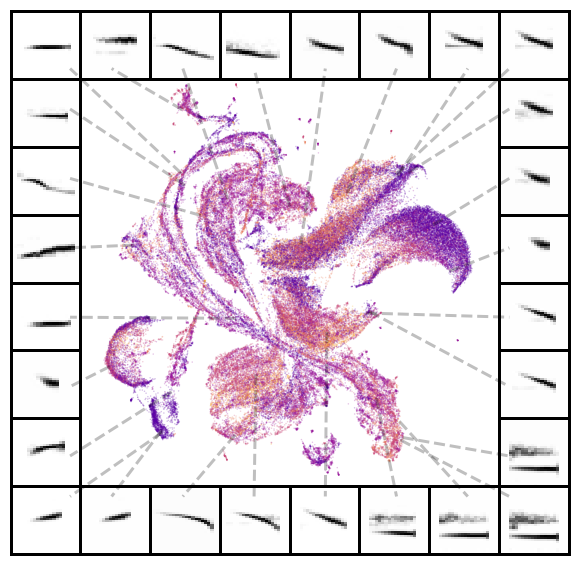

In [25]:
nex = -1
scatter_spec(
    embedding[mask][:nex],
    specs[mask][:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.pos_in_syllable.values[mask][:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': False,
        'color_palette':'plasma',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp_community', dpi=300, save_jpg=True, save_png=True)

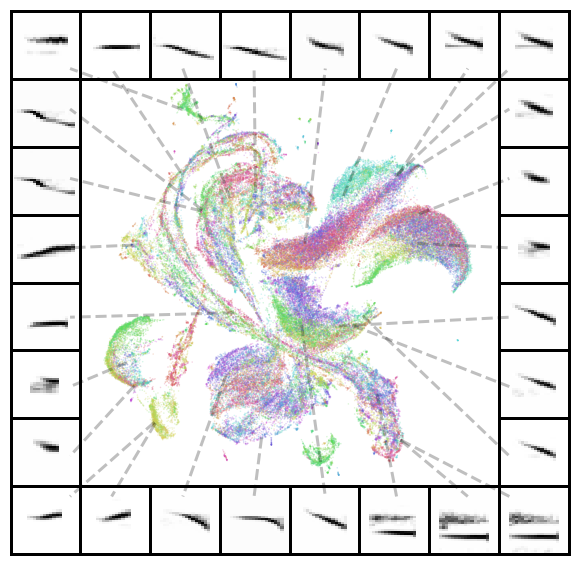

In [26]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.indv.values[:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': False,
        'color_palette':'hls',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp_community', dpi=300, save_jpg=True, save_png=True)

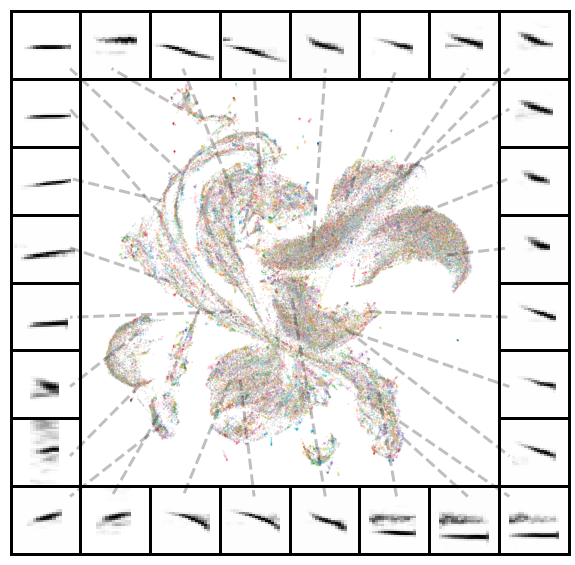

In [27]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.indv.values[:nex],
        'alpha':0.25,
        's': 0.25,
        'show_legend': False,
        'color_palette':'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp_community', dpi=300, save_jpg=True, save_png=True)